In [88]:
import do_mpc
import numpy as np
from casadi import *
import math

In [89]:
model_type = 'discrete' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

#Set state, input and parameters
I = model.set_variable(var_type="states", var_name="I", shape=(1,1))

V = model.set_variable(var_type="inputs", var_name="V", shape=(1,1))

G = 4000
T = 55

In [90]:
#Set constants

# Costante di Boltzmann in Joule/Kelvin
k = np.float64(1.380649e-23)

# Carica elementare in Coulomb
q = np.float64(1.602176634e-19)

const = {
    'Name': 'Canadian Solar CS5P-220M',
    'BIPV': 'N',
    'Date': '10/5/2009',
    'T_NOCT': 42.4,
    'A_c': 1.7,
    'N_s': 96,
    'I_sc_ref': 5.1,
    'V_oc_ref': 59.4,
    'I_mp_ref': 4.69,
    'V_mp_ref': 46.9,
    'alpha_sc': 0.004539,
    'beta_oc': -0.22216,
    'Vt': 2.6373, 
    'I_L_ref': 5.114,
    'I_o_ref': 8.196e-10,
    'R_s': 1.065,
    'R_sh_ref': 381.68,
    'Adjust': 8.7,
    'gamma_r': -0.476,
    'Version': 'MM106',
    'PTC': 200.1,
    'Technology': 'Mono-c-Si',
    'G_ref': 4500,
    'T_ref': 25,
    'EgRef': 1.121
}

In [91]:
#Define some principal expressions
Iph = G/const['G_ref'] * (const['I_sc_ref'] - const['alpha_sc']*(T-const['T_ref']))
I0 = const['I_o_ref'] * ((T / const['T_ref']) ** 3) * (math.exp((q * const['EgRef']) / (k * const['gamma_r']) * (1 / const['T_ref'] - 1 / T)))
Vt = const['Vt']
Rs = const['R_s']
Rsh = const['R_sh_ref'] * (const['G_ref'] / G)

In [92]:
#Define the equation of the model
model.set_rhs('I', Iph - (I0 * (exp((V + (Rs* I)) / Vt) - 1)) - (V + (Rs* I)) / Rsh)

In [93]:
model.setup()
mpc = do_mpc.controller.MPC(model)

setup_mpc = {
    'n_horizon': 20,
    't_step': 0.5,
    'n_robust': 1,
    'store_full_solution': True
}
mpc.set_param(**setup_mpc)

# Define the cost function
P = (400-I*V)**2
mterm = 0.1*I**2
mpc.set_objective(lterm=P, mterm=mterm)

# Bounds on state:
mpc.bounds['lower','_x', 'I'] = 0
mpc.bounds['upper','_x', 'I'] = 21

# Bounds on input:
mpc.bounds['lower','_u', 'V'] = 0
mpc.bounds['upper','_u', 'V'] = 59.4

mpc.setup()

In [94]:
simulator = do_mpc.simulator.Simulator(model)

simulator.set_param(t_step = 0.1)
simulator.setup()

x0 = np.array([5]).reshape(-1,1)

simulator.x0 = x0
mpc.x0 = x0

mpc.set_initial_guess()

In [95]:
%%capture
import matplotlib.pyplot as plt
import matplotlib as mpl
# Customizing Matplotlib:
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['axes.grid'] = True
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
sim_graphics = do_mpc.graphics.Graphics(simulator.data)

# We just want to create the plot and not show it right now. This "inline magic" supresses the output.
fig, ax = plt.subplots(2, sharex=True, figsize=(16,9))
fig.align_ylabels()

for g in [sim_graphics, mpc_graphics]:
    # Plot the angle positions (phi_1, phi_2, phi_2) on the first axis:
    g.add_line(var_type='_x', var_name='I', axis=ax[0])

    # Plot the set motor positions (phi_m_1_set, phi_m_2_set) on the second axis:
    g.add_line(var_type='_u', var_name='V', axis=ax[1])


ax[0].set_ylabel('Current')
ax[0].set_xlabel('time [s]')
ax[1].set_ylabel('Voltage')
ax[1].set_xlabel('time [s]')

for i in range(600):
    u = mpc.make_step(x0)
    x_next = mpc.make_step(u)
    x0 = mpc.make_step(x_next)
    



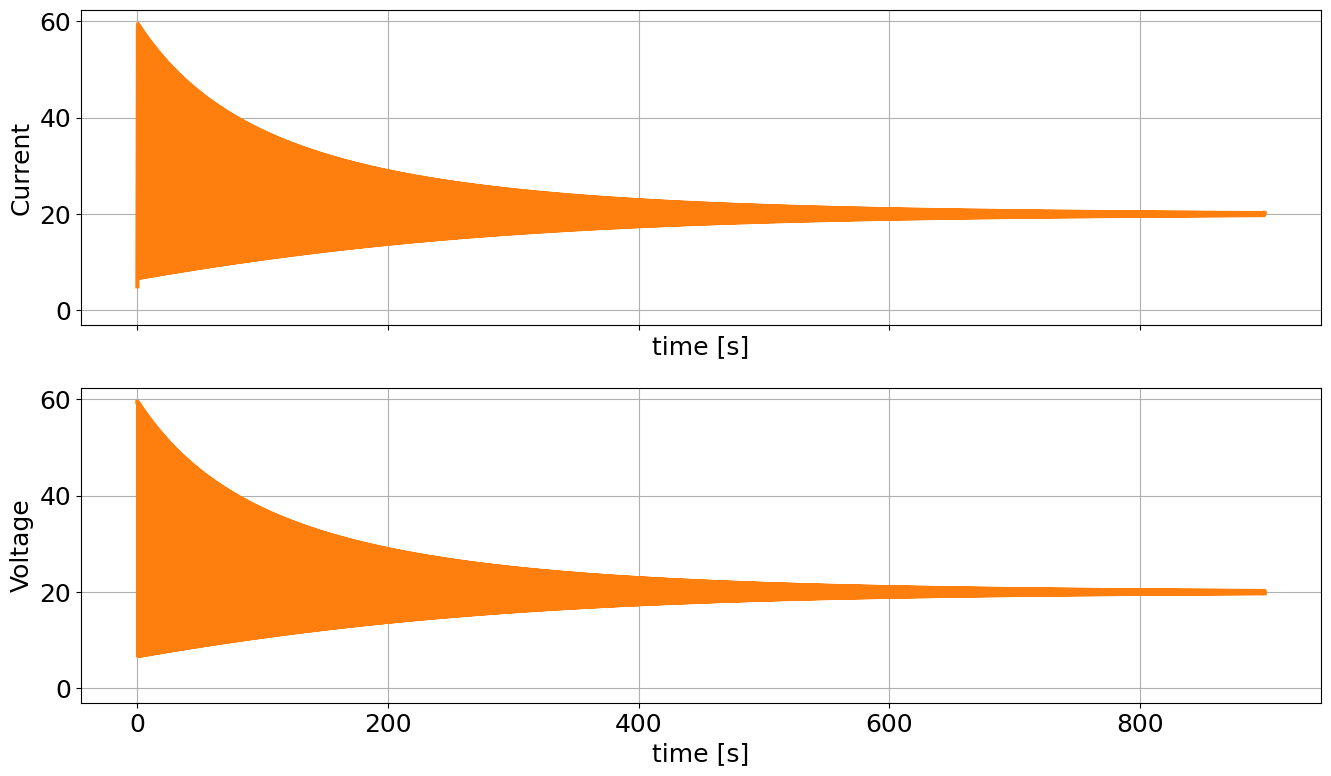

In [96]:
sim_graphics.clear()

mpc_graphics.plot_results()
mpc_graphics.reset_axes()

fig